# Finding the Best Neighbourhood

## Introduction

In order to find the best neighbourhood in Pittsburgh, we took the route to find the most chaotic, or in other words "livable", neighbourhood within the city.

While one might find it strange that the degree of chaos of a neighbourhood can be a good thing, we argue that the chaos within the neighbourhood show signs of life activities within the neighbourhood. On one wants to live in a dead neighbourhood where no one else is living in. A chaotic neighbourhood might have some danger, but it guarantees that the people in your community are active in their day to day lives. And you can wake up in the morning knowing that there will always be activity around.

## The Metric

We will use three submetric to calculate the final result for the most livable neighbourhood. Number of Arrests, number of fire incidents, and number of car crashes. All the numbers will be used on a per square mile basis to ensure that large neighbourhood and small neighbourhood will be much more even in the competition.

To get the final results, we score each neighborhood on a linear scale where it's score for X category is the it's metric for that category divided by the maximum of that category among all neighborhoods.

For example, it the maximum arrests per square mile among all neighborhoods is 50 and neighborhood Y had 25 arrests per square mile, it's score for arrests would be 25 / 50 = 0.5.

To get the overall score, we simply take the average of our scoring system for each of the individual categories and multiply that by 100. This way, we get a nice number out of 100 and each neighborhood is weighted equally.

This will also make sure that each submetric will have an equal contribution towards the final result.

## Importing Data

Here, we import the modules we need for the metric, including **pandas**, **Geopandas**, and **Matplotlib**. Then we import the neighbourhood map.

After that is done, we will be processing the individual data.

In [30]:
# Set Up
#Imports pandas, geopandas, and matplotlib
import pandas as pd
import geopandas
import matplotlib.pyplot as plt

#Imports the neighborhoods GDF
neighborhood_gdf = geopandas.read_file("Neighborhoods_.shp").set_index('hood')
#Correcting for some oddities in neighborhoods data where sqmiles is plain wrong for select neighborhoods
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212
neighborhood_gdf.at['Lincoln-Lemington-Belmar','sqmiles'] = 1.812
neighborhood_gdf.at['Marshall-Shadeland','sqmiles'] = 1.254

## Arrest

In [31]:
# Arrest Data
#Reads Dom's arrest csv and filters by years
arrest = pd.read_csv("arrests.csv")
arrest_mask = (arrest["ARRESTTIME"].str[:4].astype('int') >= 2017) & (arrest["ARRESTTIME"].str[:4].astype('int') <= 2020)
arrest_4 = arrest[arrest_mask]

#Adds column for Dom's arrests labeled 'arrests'
filterarrest = arrest_4.groupby("INCIDENTNEIGHBORHOOD")["OFFENSES"].count()
filterarrest=filterarrest.rename(index={'Mt. Oliver Neighborhood':'Mt. Oliver'})
try:
    neighborhood_gdf.insert(0,"arrests",filterarrest)
except ValueError:
    neighborhood_gdf['arrests'] = filterarrest
neighborhood_gdf['arrests'] = neighborhood_gdf['arrests'].fillna(0)

### Fire Incidents

The data for this section came from the WPRDC website's fire alarm data.

In order to properly organise the data I got, I imported th data from the csv file into a python **dictionary**. This way, I can easily print out the content of the data I need in ways I want to present it.

In order to align the dates of the data, I filter the incoming data so only fire alarm data from the year 2016-2020 will be taken into acccount.

After the importing is done, I will make a dataframe out of the dictionary, and conatenate the dataframe to the overall dataframe.|

In [32]:
# Fire Incident data
#Reads Alex's fire incidents csv
fire_data = pd.read_csv("Fire_Alarm.csv")
#Adds column for Alex's fire incidents labeled 'fires'
neighbourhood_dictionary = {}
name = ""
counter = 0
neighbourhood_counter = 0
# put all data into a dictionary
for index, row in fire_data.iterrows():
    neighborhood = row["neighborhood"]
    time = row["alarm_time"]
    if(type(time) == str):
        if(time.startswith("2017") or time.startswith("2018") or time.startswith("2019") or time.startswith("2020")):
            if(neighborhood not in neighbourhood_dictionary.keys()):
                neighbourhood_dictionary.update({neighborhood: [neighborhood, 1]})
                continue
            counter = neighbourhood_dictionary[neighborhood]
            counter[1] += 1
            neighbourhood_dictionary.update({neighborhood: counter})
# Import the data from the dictionary into a dataframe
neighborhood_df = pd.DataFrame.from_dict(neighbourhood_dictionary, orient = "index")
neighborhood_df.columns = ["Neighbourhood", "Number of Incidents"]
neighborhood_df = neighborhood_df.dropna()
neighborhood_df = neighborhood_df.drop(index=['Mount Oliver Borough'])
# Add the dataframe's value to the concatenate dataframe
try:
    neighborhood_gdf.insert(1,"fires", neighborhood_df['Number of Incidents'])
except ValueError:
    neighborhood_gdf['fires'], neighborhood_df['Number of Incidents']
neighborhood_gdf['fires'] = neighborhood_gdf['fires'].fillna(0)

### Car Crashes

Here, I took data from the Allegheny County Car Crashes data set, which spans from 2004 to 2020.

I used query masking to filter out any data that wasn't from 2017 to 2020 as that's where out three data sets lined up.

I looped through the neighborhoods and used the within method (part of geopandas) to count the crashes in each neighborhood and add that data as a column of nieghborhood_gdf.

In [33]:
# Crash Data
#Grabs Sean's data from the WPRDC (Will probably be redone to just store the stuff in the files)
crashes_2020_url = "https://data.wprdc.org/datastore/dump/514ae074-f42e-4bfb-8869-8d8c461dd824"
crashes_2019_url = "https://data.wprdc.org/datastore/dump/cb0a4d8b-2893-4d20-ad1c-47d5fdb7e8d5"
crashes_2018_url = "https://data.wprdc.org/dataset/3130f583-9499-472b-bb5a-f63a6ff6059a/resource/48f30bee-e404-4cf5-825b-b0da3c975e45/download/crash-data-2018.csv"
crashes_2017_url = "https://data.wprdc.org/datastore/dump/bf8b3c7e-8d60-40df-9134-21606a451c1a"
crashes_2016_url = "https://data.wprdc.org/datastore/dump/9ccea350-e062-45e2-ade5-45e9378f40d2"
crashes_df=pd.concat([pd.read_csv(crashes_2020_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2019_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2018_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2017_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']],
                          pd.read_csv(crashes_2016_url,low_memory=False).dropna(subset=['DEC_LAT', 'DEC_LONG'])[['DEC_LAT','DEC_LONG']]
                         ],ignore_index=True)
crashes_gdf = geopandas.GeoDataFrame(crashes_df, geometry=geopandas.points_from_xy(crashes_df.DEC_LONG, crashes_df.DEC_LAT, crs=4326))
neighborhood_gdf.at['Perry North','sqmiles'] = 1.212
#Adds column for Sean's crashes labeled 'crashes'
pittsburgh_crashes = geopandas.GeoDataFrame(columns=crashes_gdf.columns.append(pd.Index(['hood'])), geometry='geometry', crs=4326)
crash_count = []
for i in neighborhood_gdf.index:
    bool_crashes = crashes_gdf.within(neighborhood_gdf.loc[i].geometry)
    try:
        count = bool_crashes.value_counts().loc[True]
    except KeyError:
        count = 0
    crash_count.append(count)
    neighborhood_crashes = crashes_gdf[bool_crashes].assign(hood=i)
    pittsburgh_crashes = pd.concat([neighborhood_crashes, pittsburgh_crashes])
try:
    neighborhood_gdf.insert(1, "crashes", pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index)))
except ValueError:
    neighborhood_gdf['crashes'] = pd.to_numeric(pd.Series(crash_count, index=neighborhood_gdf.index))

In [34]:
#Adds columns to neighborhood_gdf for x per square mile
neighborhood_gdf = neighborhood_gdf.assign(arrests_sqmile = lambda x: x['arrests'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(fires_sqmile = lambda x: x['fires'] / x['sqmiles'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_sqmile = lambda x: x['crashes'] / x['sqmiles'])

## Plotting the Data

### Arrests

,sqmiles,arrests,arrests_sqmile
hood,,,
East Allegheny,0.236,1366.0,5788.135593
Central Business District,0.640,2614.0,4084.375000
Allegheny Center,0.210,771.0,3671.428571
Homewood South,0.398,1409.0,3540.201005
Homewood North,0.434,1288.0,2967.741935


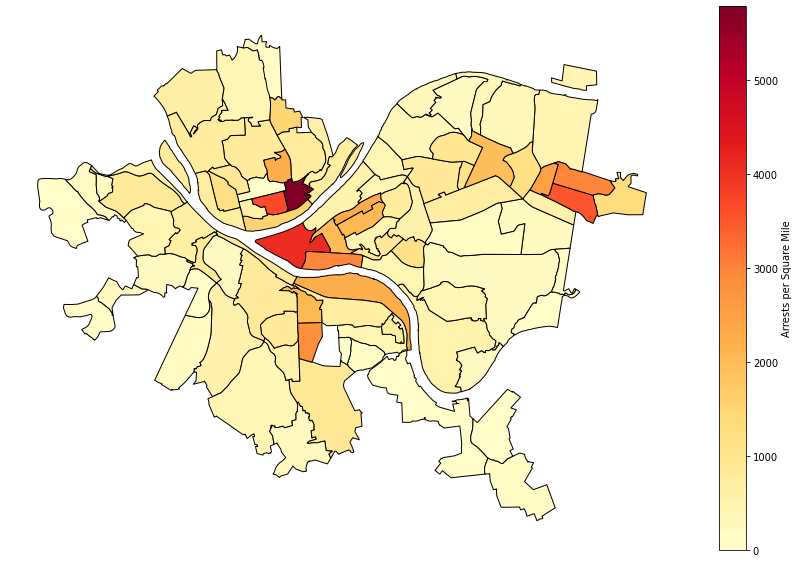

In [35]:
#Arrests Plot
neighborhood_gdf.plot(figsize=(15,10), column = "arrests_sqmile",
                    cmap = "YlOrRd",
                   legend = True,
                   legend_kwds = {"label":"Arrests per Square Mile"},
                   edgecolors = "black")
plt.axis("off")
neighborhood_gdf.sort_values('arrests_sqmile', ascending=False)[['sqmiles','arrests','arrests_sqmile']].head(5)

### Fire Incidents

For this section, we will look at the number of fire incidents per square mile of each neighbourhood.

But before we plot the data out, lets take a look at the top 5 most livable neighbourhood in Pittsburgh. 

Then we will plot the data out with **geopandas** to see if the results match.

,sqmiles,fires,fires_sqmile
hood,,,
East Allegheny,0.236,53.0,224.576271
Knoxville,0.302,65.0,215.231788
Central Northside,0.259,44.0,169.884170
Bluff,0.327,51.0,155.963303
Homewood North,0.434,59.0,135.944700


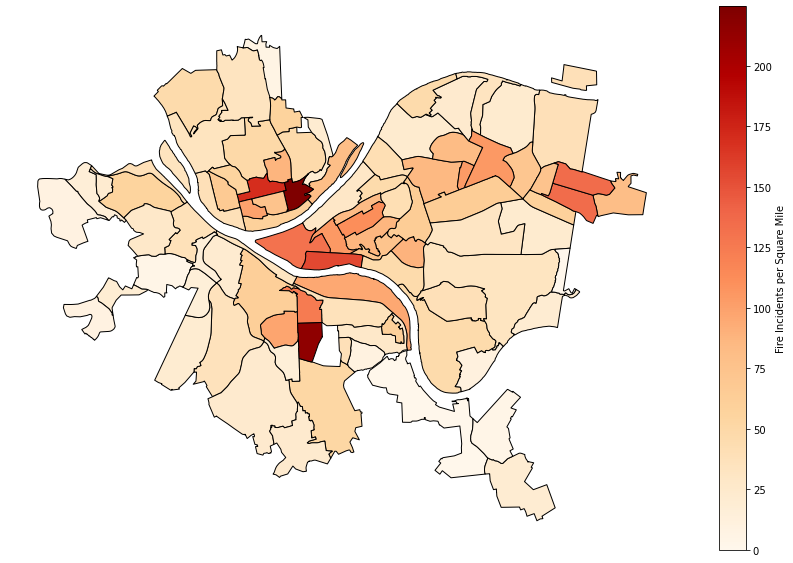

In [40]:
#Fire Incidents Plot
neighborhood_gdf.plot(column='fires_sqmile',
              cmap='OrRd',            
              edgecolor="black",      
              legend=True,              
              legend_kwds={'label': "Fire Incidents per Square Mile"}, 
              figsize=(15, 10),         
              )
plt.axis("off")
neighborhood_gdf.sort_values('fires_sqmile', ascending=False)[['sqmiles','fires','fires_sqmile']].head(5)

So, as the data shown, the most livable neighbourhood in Pittsburgh, according to the number of fire incidents alone, will be **East Allegheny**, coming in at second place is **Knoxville**, and coming in at third place is **Central Northside**.

But nonetheless, this only accounts for a part of the total data used for the final calculation, and all the neighbourhood will be taken into account for the final calculation, no matter the ranking they got here.

### Car Crashes

Here, we plot the car crashes per square mile in each neighborhood. In first place is **Bluff**, with over 1500 crashes per square mile. Not far behind in second place is the **Central Business District**, more commonly known as Downtown. In third is **East Allegheny** with nearly 1300 crashes per square mile over 4 years.

,sqmiles,crashes,crashes_sqmile
hood,,,
Bluff,0.327,630,1926.605505
Central Business District,0.640,1151,1798.437500
East Allegheny,0.236,391,1656.779661
West End,0.200,312,1560.000000
South Shore,0.212,328,1547.169811


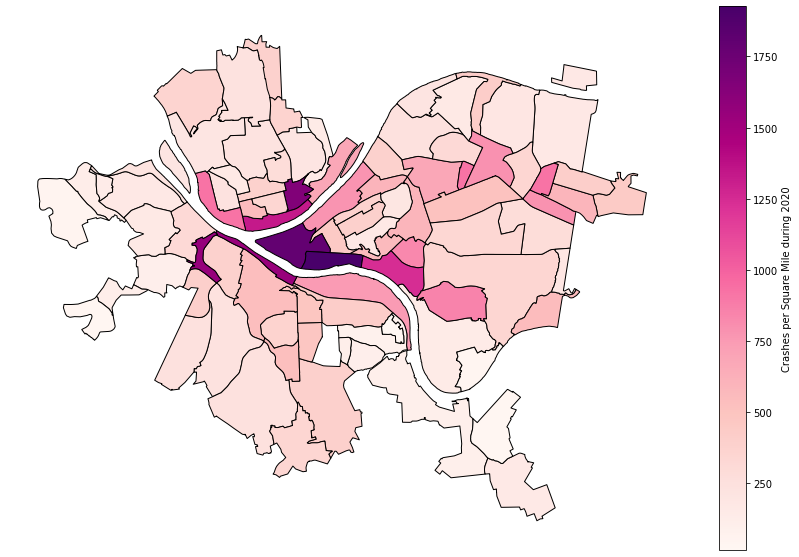

In [37]:
#Crashes Plot
neighborhood_gdf.plot(column='crashes_sqmile',
                      cmap="RdPu",
                      edgecolor="black",
                      legend=True,
                      legend_kwds={'label':'Crashes per Square Mile during 2020'},
                      figsize=(15,10))
plt.axis('off')
neighborhood_gdf.sort_values('crashes_sqmile', ascending=False)[['sqmiles','crashes','crashes_sqmile']].head(5)

### Final Results and Conclusions

Now at last we will calculate the scores and plot out the final winner.

In [9]:
max_series = neighborhood_gdf[['arrests_sqmile','fires_sqmile','crashes_sqmile']].max()
neighborhood_gdf = neighborhood_gdf.assign(arrests_1 = lambda x: x['arrests_sqmile'] / max_series['arrests_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(fires_1 = lambda x: x['fires_sqmile'] / max_series['fires_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(crashes_1 = lambda x: x['crashes_sqmile'] / max_series['crashes_sqmile'])
neighborhood_gdf = neighborhood_gdf.assign(score = lambda x: (x['arrests_1'] + x['fires_1'] + x['crashes_1']) / 3 * 100)

,sqmiles,arrests,fires,crashes,arrests_sqmile,fires_sqmile,crashes_sqmile,score
hood,,,,,,,,
East Allegheny,0.236,1770.0,62,391,7500.000000,262.711864,1656.779661,93.481975
Central Business District,0.640,3313.0,126,1151,5176.562500,196.875000,1798.437500,77.716518
Bluff,0.327,1219.0,69,630,3727.828746,211.009174,1926.605505,75.189068
Marshall-Shadeland,0.231,1253.0,58,258,5424.242424,251.082251,1116.883117,73.521611
Knoxville,0.302,1119.0,84,145,3705.298013,278.145695,480.132450,58.108378
Homewood South,0.398,1741.0,70,236,4374.371859,175.879397,592.964824,50.778496
Homewood North,0.434,1642.0,86,180,3783.410138,198.156682,414.746544,47.738278
Allegheny Center,0.210,1014.0,29,73,4828.571429,138.095238,347.619048,44.024187
South Side Flats,0.936,2840.0,132,701,3034.188034,141.025641,748.931624,43.343678


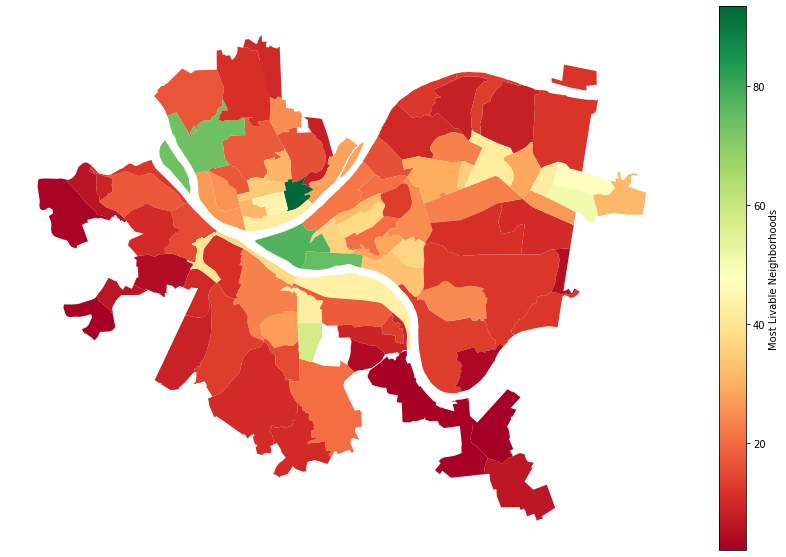

In [19]:
neighborhood_gdf.plot(column='score',
                      cmap="RdYlGn",
                      legend=True,
                      legend_kwds={'label':'Most Livable Neighborhoods'},
                      figsize=(15,10))
plt.axis('off')

### Conclusion

Alas, from the results, we can see that:
#### At third place, we have Bluff.
#### At second place, we have the Central Business District.
#### And at FIRST PLACE, we have East Allegheny.

It just makes sense for East Allegheny to be the final winner. As it won the Gold in arrests per square mile, another Gold in fire incidents per square mile, and the Bronze in car crashes per square mile.

### Alex's Conclusion

So from the final results, we know that **East Allegheny** won out as the most livable neighbourhood. And from the fire incident data, we know that **East Allegheny** came in first for that section. Although Central Business District did not make it into the top 5 for the fire incidents, it is still safe to say that the data is somewhat consistent to the final result as those who ranked high on the fire incident data, like Knoxville, Bluff, and Homewood North all ranked relatively high on the fire result list.

### Sean's Conclusion

I'm from Brookline so it would have been nice to have my own neighborhood as our best neighborhood, but unfortunatley Brookline came in about 70th place. Admittedly Brookline doesn't have much chaos over the great East Allegheny. I am actually quite surprised by East Allegheny coming in first though. I've lived in Pittsburgh for 19 years now and have never heard much of anything about East Allegheny. I would've expected Downtown or maybe Homewood to come in first, but East Allegheny, a neighborhood I hardly even knew was a neighborhood, takes the cake as most Chaotic neighborhood.

### Dominic's Conclusion

As someone who lives 5 minutes from the East Allegheny area, I am not entirely surprised by this outcome. I grew up in the Homewood area, so from personal experience I am not surprised to see it high on the list, but I will say it was slightly revealing to see that East Allegheny comes through as the most chaotic over Homewood and some of the more densely populated areas of Allegheny County. I suppose I can be proud that the area I'm in ranks number 1 on our list, but the context isn't quite an achievement I'd boast about.